<a href="https://colab.research.google.com/github/pedrohortencio/cancer-detection/blob/main/PCam/Detec%C3%A7%C3%A3o_Histopatol%C3%B3gica_de_C%C3%A2ncer_PCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção Histopatológica de Câncer Utilizando Aprendizado por Transferência

![](https://raw.githubusercontent.com/basveeling/pcam/master/pcam.jpg)

>## Universidade Federal de Goiás
>
>### Alunos:
>
>>* Gustavo M. R. 
>>
>>* Iago S. S.
>>
>>* Pedro H. M. R.




####Fonte dos Dados Utilizados:
<blockquote>

[Detecção Histopatológica de Câncer - Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

[PatchCamelyon (PCam) Dataset](https://github.com/basveeling/pcam)

</blockquote>
<hr>

## Importação de Bibliotecas e Download dos Dados

In [ ]:
import pandas as pd
import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import cv2
import os
import shutil


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Concatenate, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.metrics import plot_roc_curve

tf.random.set_seed(42)  #torna os números aleatórios gerados previsíveis, 
seed(42)    #de modo a ter consistência entre execuções. 42 escolhido arbitrariamente.


# Constantes
TAMANHO_IMAGEM = 96
CANAIS_IMAGEM = 3
TAMANHO_AMOSTRA = 80000

BATCH_SIZE_TREINO = 100
BATCH_SIZE_TESTE = 100

DATASET_PATH = "/content/dataset/"

# Muda o estilo de figuras que serão criadas no notebook
sns.set_theme(style='white', palette='deep')

>Os códigos da célula abaixo são necessários para o download do dataset do Kaggle. Para a correta execução, é necessário que seja gerado o arquivo ```kaggle.json```, que contém a autorização para uso da API. Mais informações podem ser obtidas na documentação da [API do Kaggle](https://www.kaggle.com/docs/api).

In [ ]:
# Atualiza API do Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle 

!mkdir -p ~/.kaggle                 # Cria o diretório para o arquivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json    # Muda as permissões do arquivo
!cp kaggle.json ~/.kaggle/          # Copia o arquivo kaggle.json para o diretório recém criado

# Download do arquivo zip para o caminho definido
!kaggle competitions download -c histopathologic-cancer-detection -p {DATASET_PATH}

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=f1adb424a35ce376aaf325bf221f31165bafdffd16848eacee9aa4449abff38a
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
100% 6.30G/6.31G [02:22<00:00, 42.0MB/s]
100% 6.31G/6.31G [02:22<00:00, 47.5MB/s]


In [ ]:
# Unzip do arquivo
!unzip -q {DATASET_PATH}histopathologic-cancer-detection.zip -d {DATASET_PATH}

## Criação de DataFrames

> O arquivo ```train_labels.csv``` contém o nome das imagens (armazenadas em duas pastas distintas, uma para treino e outra para teste) e o seu respectivo label.

In [ ]:
df_dados = pd.read_csv(f'{DATASET_PATH}train_labels.csv')   # Cria um DataFrame
print(df_dados.shape)                                       # Formato (Linhas, Colunas)
df_dados.head(3)                                            # 3 primeiras linhas

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [ ]:
# Checa a quantidade de imagens em cada diretório
print("Quantidade de Amostras de Treino:",
      len(os.listdir('/content/dataset/train')))

print("Quantidade de Amostras de Teste:",
      len(os.listdir('/content/dataset/test')))

Quantidade de Amostras de Treino: 220025
Quantidade de Amostras de Teste: 57458


> Plot para Visualização da Distribuição de Amostras para cada um dos labels

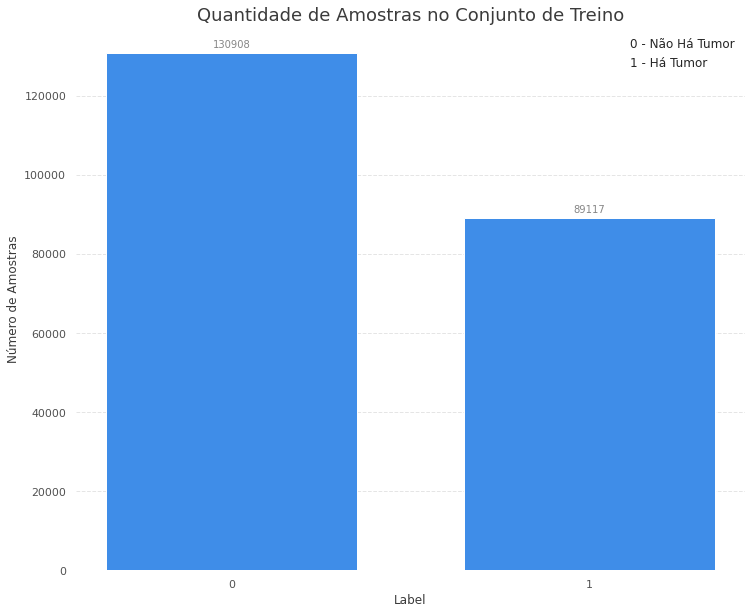

In [ ]:
#@title Distribuição de amostras entre classes (original)
#@markdown _duplo clique para exibir o código_

count_label = df_dados['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Quantidade de Amostras no Conjunto de Treino", size=18, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
plt.legend(handles=[patch_legenda0, patch_legenda1],
           edgecolor='white',
           prop={'size':12},
           )

plt.show();

In [ ]:
# Iguala a quantidade de amostras com label 0 e amostras com label 1

df_0 = df_dados[df_dados['label'] == 0].sample(TAMANHO_AMOSTRA + 9000,
                                               random_state = 42)    # Apenas imagens com label 0
df_1 = df_dados[df_dados['label'] == 1].sample(TAMANHO_AMOSTRA + 9000,
                                               random_state = 42)    # Apenas imagens com label 1

# Concatena os dataframes e embaralha (shuffle) as imagens
df_dados = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_dados = shuffle(df_dados)

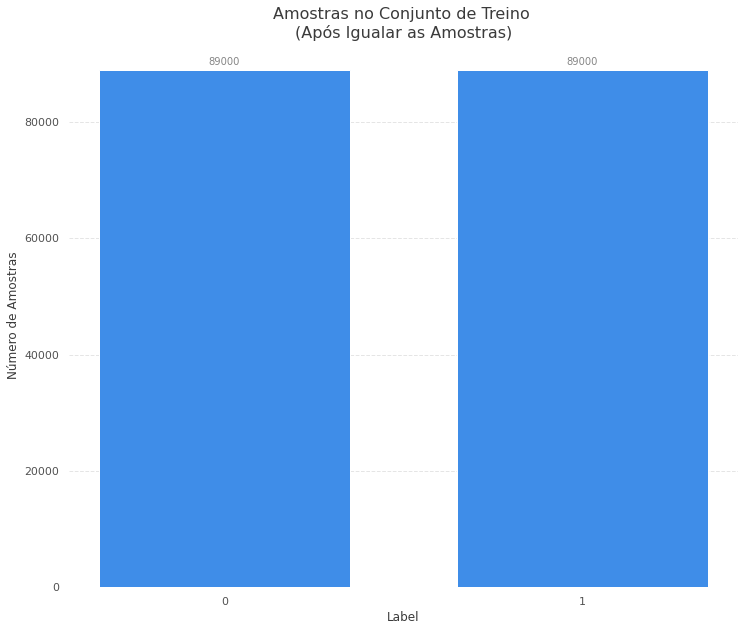

In [ ]:
#@markdown Distribuição após igualar a quantidade de amostras por classe
#@markdown
#@markdown _duplo clique para exibir o código_

count_label = df_dados['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Amostras no Conjunto de Treino \n(Após Igualar as Amostras)", size=16, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
#plt.legend(handles=[patch_legenda0, patch_legenda1],
#           edgecolor='white',
#           framealpha = 0,
#           prop={'size':12},
#           )

plt.show();

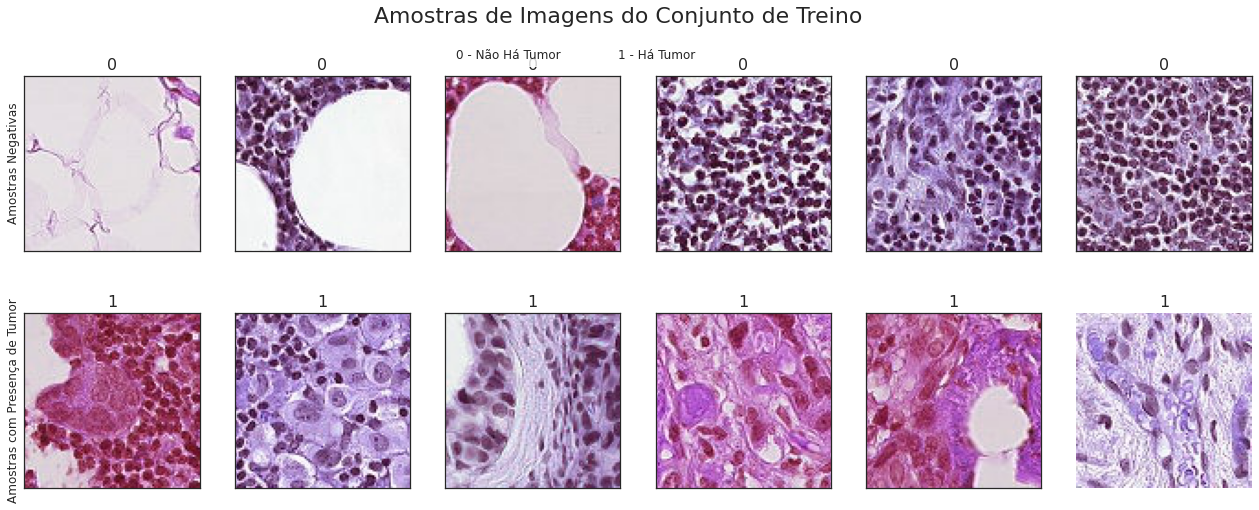

In [ ]:
#@title Exemplo de Imagens
#@markdown A seleção de imagens a serem exibidas é aleatória
#@markdown
#@markdown _duplo clique exibe o código_

# Constantes que serão usadas nessa célula
nome_coluna = 'label'
figure_cols = 6
df = df_dados
IMAGE_PATH = '/content/dataset/train/' 

# Cria uma variável index com os valores dos labels e o nome da coluna
categories = (df.groupby([nome_coluna])[nome_coluna].nunique()).index

# Cria a figura
f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                      figsize=(22,8))

# Loop sobre o index criado anteriormente
for i, cat in enumerate(categories):
    # Seleciona aleatoriamente (figure_cols) imagens
    sample = df[df[nome_coluna]==cat].sample(figure_cols)

    # Loop que preenche os subplots com as imagens elecionadas
    for j in range(0,figure_cols):
        file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'     # Gera o caminho da imagem
        im=cv2.imread(file)                                 # Lê a imagem
        ax[i, j].imshow(im, resample=True, cmap='gray')     # Plota a imagem
        ax[i, j].set_title(cat, fontsize=16)                # Cria um título
        ax[i, j].grid(False)                                # Desabilita o grid
        plt.box(False)                              # Desabilita a caixa do gráfico
        ax[i, j].set_xticks([])                     # Desabilita os números no eixo x
        ax[i, j].set_yticks([])                     # Desabilita os números no eixo y

# Cria labels (do matplotlib) para serem exibidos na legenda da imagem
patch_legenda0 = mpatches.Patch(color='none',   
                                label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none',
                                label='1 - Há Tumor')

ax[0,0].set_ylabel('Amostras Negativas', size='large')
ax[1,0].set_ylabel('Amostras com Presença de Tumor', size='large')

# Adiciona uma legenda na imagem, com base nos labels anteriores
f.legend(handles=[patch_legenda0, patch_legenda1],
           edgecolor='white',                   # Cor da borda
           prop={'size':12},                    # Tamanho da fonte
           ncol=2,                              # Número de colunas
           bbox_to_anchor=(0.26, .76, 1, 1),    #(x, y, width, height)
           loc=3,                               # Posição
           )
f.suptitle("Amostras de Imagens do Conjunto de Treino",
           size=22, y=0.98)

# Salva a imagem
plt.savefig("Amostra-Treino.png",
            bbox_inches='tight', dpi=100)

# Realiza o plot
plt.show()

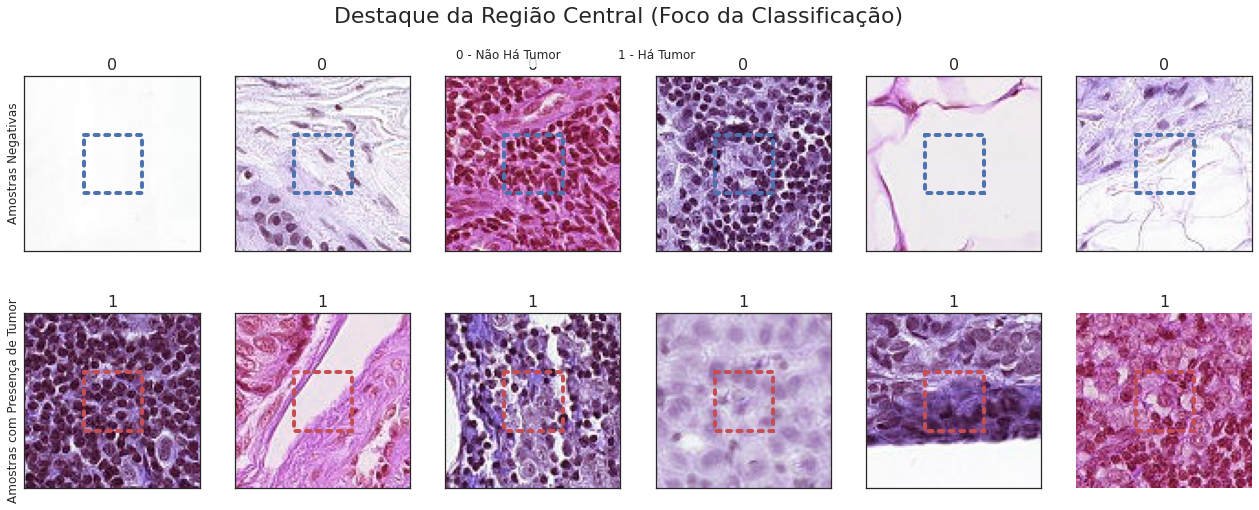

In [ ]:
#@title Exemplo de Imagens (Com Destaque Para a Região Central)
#@markdown A seleção de imagens a serem exibidas é aleatória. O destaque é feito na região central das imagens, de tamanho 32x32 pixels, e delimita a região que é levada em consideração para a classificação dos labels originais.
#@markdown
#@markdown _duplo clique exibe o código_

# Constantes que serão usadas nessa célula
nome_coluna = 'label'
figure_cols = 6
df = df_dados
IMAGE_PATH = '/content/dataset/train/' 

# Cria uma variável index com os valores dos labels e o nome da coluna
categories = (df.groupby([nome_coluna])[nome_coluna].nunique()).index

# Cria a figura
f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                      figsize=(22,8))

# Loop sobre o index criado anteriormente
for i, cat in enumerate(categories):
    # Seleciona aleatoriamente (figure_cols) imagens
    sample = df[df[nome_coluna]==cat].sample(figure_cols)

    # Loop que preenche os subplots com as imagens elecionadas
    for j in range(0,figure_cols):
        file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'     # Gera o caminho da imagem
        im=cv2.imread(file)                                 # Lê a imagem
        ax[i, j].imshow(im, resample=True, cmap='gray')     # Plota a imagem
        
        if cat == 0:
            color = 'b'
        else:
            color = 'r'
        
        box = mpatches.Rectangle((32,32),32,32,linewidth=4,edgecolor=color,facecolor='none', linestyle=':', capstyle='round')
        ax[i, j].add_patch(box)
        ax[i, j].set_title(cat, fontsize=16)                # Cria um título
        ax[i, j].grid(False)                                # Desabilita o grid
        plt.box(False)                              # Desabilita a caixa do gráfico
        ax[i, j].set_xticks([])                     # Desabilita os números no eixo x
        ax[i, j].set_yticks([])                     # Desabilita os números no eixo y

# Cria labels (do matplotlib) para serem exibidos na legenda da imagem
patch_legenda0 = mpatches.Patch(color='none',   
                                label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none',
                                label='1 - Há Tumor')

ax[0,0].set_ylabel('Amostras Negativas', size='large')
ax[1,0].set_ylabel('Amostras com Presença de Tumor', size='large')

# Adiciona uma legenda na imagem, com base nos labels anteriores
f.legend(handles=[patch_legenda0, patch_legenda1],
           edgecolor='white',                   # Cor da borda
           prop={'size':12},                    # Tamanho da fonte
           ncol=2,                              # Número de colunas
           bbox_to_anchor=(0.26, .76, 1, 1),    #(x, y, width, height)
           loc=3,                               # Posição
           )
f.suptitle("Destaque da Região Central (Foco da Classificação)",
           size=22, y=0.98)

# Salva a imagem
plt.savefig("Amostra-Treino-Patch.png",
            bbox_inches='tight', dpi=100)

# Realiza o plot
plt.show()

## Criando DataFrames de Treino, Validação de Teste 1 (Local)

In [ ]:
y = df_dados['label']           # Array de labels

df_treino, df_val = train_test_split(df_dados,
                                    train_size=int(2*TAMANHO_AMOSTRA*0.75),     # Conjunto de teste com 120000 imagens
                                    random_state=42,
                                    stratify=y)         # Cria uma divisão balanceada

df_val, df_test = train_test_split(df_val,
                                    test_size=2*9000,     # Conjunto de teste (local) com 18000 imagens
                                    random_state=42,
                                    stratify=df_val['label'])         # Cria uma divisão balanceada


print("Dataset de treino:", df_treino.shape)
print("Dataset de validação:", df_val.shape)
print("Dataset de teste 1:", df_test.shape)

Dataset de treino: (120000, 2)
Dataset de validação: (40000, 2)
Dataset de teste 1: (18000, 2)


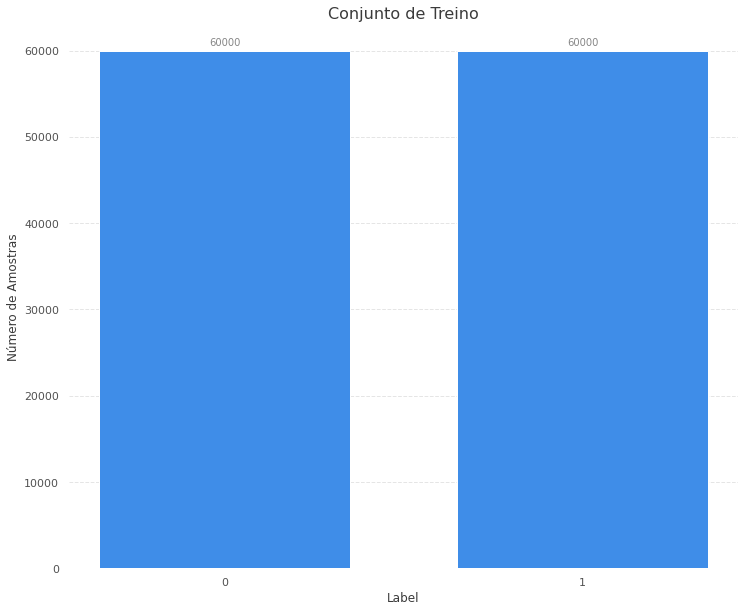

In [ ]:
#@markdown Distribuição do Conjunto Final de Treino
#@markdown
#@markdown _duplo clique para exibir o código_

count_label = df_treino['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Conjunto de Treino", size=16, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
#plt.legend(handles=[patch_legenda0, patch_legenda1],
#           edgecolor='white',
#           framealpha = 0,
#           prop={'size':12},
#           )

plt.show();

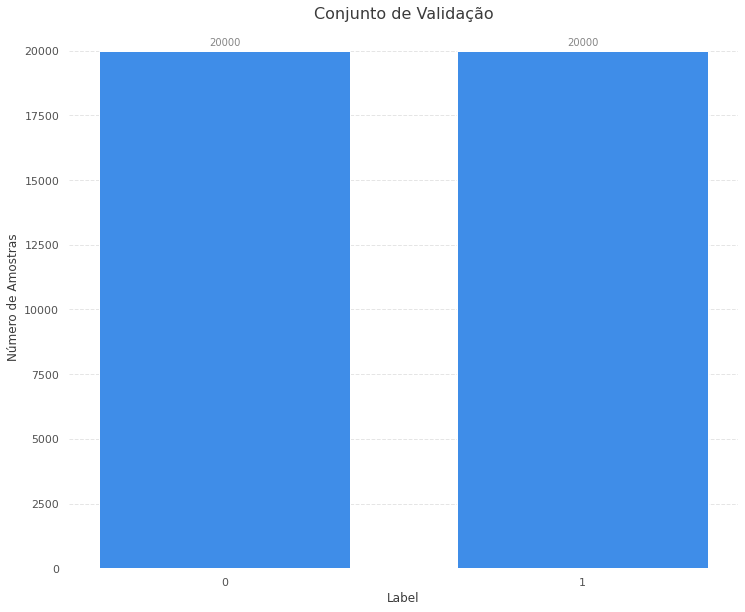

In [ ]:
#@markdown Distribuição do Conjunto Final de Validação
#@markdown
#@markdown _duplo clique para exibir o código_

count_label = df_val['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Conjunto de Validação", size=16, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
#plt.legend(handles=[patch_legenda0, patch_legenda1],
#           edgecolor='white',
#           framealpha = 0,
#           prop={'size':12},
#           )

plt.show();

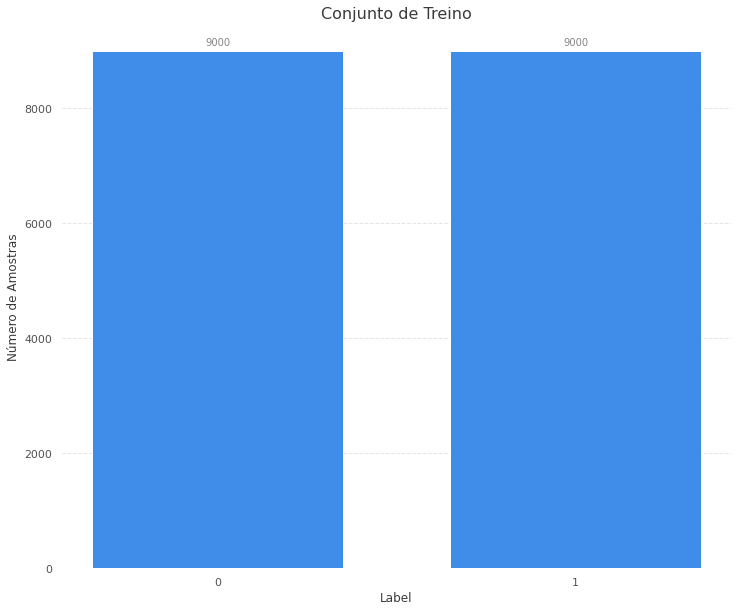

In [ ]:
#@markdown Distribuição do Conjunto de Testes 1
#@markdown
#@markdown _duplo clique para exibir o código_

count_label = df_test['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Conjunto de Treino", size=16, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
#plt.legend(handles=[patch_legenda0, patch_legenda1],
#           edgecolor='white',
#           framealpha = 0,
#           prop={'size':12},
#           )

plt.show();

## Estrutura de Diretórios para Utilização do Keras DataGenerator

In [ ]:
# Criando uma nova pasta/diretório
dir_base = 'dir_base'
os.mkdir(dir_base)

# Dentro da pasta "dir_base", haverá a seguinte estrutura:

# dir_treino
    # a_sem_tumor
    # b_com_tumor

# dir_val
    # a_sem_tumor
    # b_com_tumor

# dir_test1
    # a_sem_tumor
    # b_com_tumor

# Criando a pasta "dir_treino"
dir_treino = os.path.join(dir_base, 'dir_treino')
os.mkdir(dir_treino)

# Criando a pasta "dir_val"
dir_val = os.path.join(dir_base, 'dir_val')
os.mkdir(dir_val)

# Criando a pasta "dir_test1"
dir_test1 = os.path.join(dir_base, 'dir_test1')
os.mkdir(dir_test1)


# Criando as pastas que ficarão dentro das pastas "dir_treino", "dir_val" e "dir_test1"
# Dentro dessas pastas estarão as imagens correspondentes a cada um dos labels

# Crindo pastas dentro de "dir_treino"
no_tumor_tissue = os.path.join(dir_treino, 'a_sem_tumor')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(dir_treino, 'b_com_tumor')
os.mkdir(has_tumor_tissue)

# Criando pastas dentro de "dir_val"
no_tumor_tissue = os.path.join(dir_val, 'a_sem_tumor')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(dir_val, 'b_com_tumor')
os.mkdir(has_tumor_tissue)

# Criando pastas dentro de "dir_test1"
no_tumor_tissue = os.path.join(dir_test1, 'a_sem_tumor')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(dir_test1, 'b_com_tumor')
os.mkdir(has_tumor_tissue)

In [ ]:
# Checando as pastas no diretório de treino
os.listdir('dir_base/dir_treino')

['a_sem_tumor', 'b_com_tumor']

In [ ]:
# Checando as pastas no diretório de validação
os.listdir('dir_base/dir_val')

['a_sem_tumor', 'b_com_tumor']

In [ ]:
# Checando as pastas no diretório de teste local
os.listdir('dir_base/dir_test1')

['a_sem_tumor', 'b_com_tumor']

### Transferindo Imagens

In [ ]:
# Configurando o id das imagens como index do dataframe
df_dados.set_index('id', inplace=True)

In [ ]:
df_dados.head(2)

,label
id,
5c5f7734308c2246409d38c4f0ba23f1baf52137,1
19623f470313ba044917a7513f10a72c36ec95b1,1


In [ ]:
# Cria listas com base nos IDs das imagens de treino e validação
list_treino = list(df_treino['id'])
list_val = list(df_val['id'])
list_test1 = list(df_test['id'])

# Mudando as imagens de pasta
for image in list_treino:
    
    fname = image + '.tif'                  # Adiciona o .tif no final do ID
    target = df_dados.loc[image,'label']    # Identifica o label da imagem
    
    # Define a pasta em que a imagem será salva
    if target == 0:
        label = 'a_sem_tumor'
    if target == 1:
        label = 'b_com_tumor'
    
    src = os.path.join('/content/dataset/train', fname)     # Define o caminho de origem
    dst = os.path.join(dir_treino, label, fname)            # Define o caminho de destino
    
    shutil.copyfile(src, dst)                   # Copia a imagem de uma pasta para outra


### Mesmo processo, mas para as imagens de validação e testes


for image in list_val:
    
    fname = image + '.tif'
    target = df_dados.loc[image,'label']
    
    if target == 0:
        label = 'a_sem_tumor'
    if target == 1:
        label = 'b_com_tumor'
    
    src = os.path.join('/content/dataset/train', fname)
    dst = os.path.join(dir_val, label, fname)
    
    shutil.copyfile(src, dst)

for image in list_test1:
    
    fname = image + '.tif'
    target = df_dados.loc[image,'label']
    
    if target == 0:
        label = 'a_sem_tumor'
    if target == 1:
        label = 'b_com_tumor'
    
    src = os.path.join('/content/dataset/train', fname)
    dst = os.path.join(dir_test1, label, fname)
    
    shutil.copyfile(src, dst)

In [ ]:
print("Imagens de treino")
print("\t Label 0 (Sem tumor):", 
      len(os.listdir('dir_base/dir_treino/a_sem_tumor')))
print("\t Label 1 (Com tumor):", 
      len(os.listdir('dir_base/dir_treino/b_com_tumor')))

print("\nImagens de validação")
print("\t Label 0 (Sem tumor):", 
      len(os.listdir('dir_base/dir_val/a_sem_tumor')))
print("\t Label 1 (Com tumor):", 
      len(os.listdir('dir_base/dir_val/b_com_tumor')))

print("\nImagens de teste (1)")
print("\t Label 0 (Sem tumor):", 
      len(os.listdir('dir_base/dir_test1/a_sem_tumor')))
print("\t Label 1 (Com tumor):", 
      len(os.listdir('dir_base/dir_test1/b_com_tumor')))

Imagens de treino
	 Label 0 (Sem tumor): 60000
	 Label 1 (Com tumor): 60000

Imagens de validação
	 Label 0 (Sem tumor): 20000
	 Label 1 (Com tumor): 20000

Imagens de teste (1)
	 Label 0 (Sem tumor): 9000
	 Label 1 (Com tumor): 9000


## Criando Geradores (Keras)

Estamos lidando com um dataset bastante grande. Nesse caso, um desafio considerável é alimentar o modelo com as imagens sem que o sistema em questão fique sem memória RAM (já que, usualmente, todas as imagens seriam carregadas na memória e, então, fornecidas de uma só vez ao modelo).


Uma forma de contornar esse problema, para datasets com muitas imagens, é utilizar alguma ferramenta que alimenta os modelos em _batches_. Uma dessas ferrametnas é o [_ImageDataGenerator_](https://keras.io/api/preprocessing/image/), do Keras. É uma ferramenta muito poderosa para o processo de _data augmentation_, pois não só carrega as imagens em _batches_, mas também modifica as imagens antes de alimentar o modelo.


In [ ]:
train_path = 'dir_base/dir_treino'      # Caminho das imagens de treino
valid_path = 'dir_base/dir_val'         # Caminho das imagens de validação
test1_path = 'dir_base/dir_test1'       # Caminho das imagens de teste (local)
test_path = '/content/dataset/test'     # Caminho das imagens de teste (Kaggle)

num_amostras_treino = len(df_treino)    # Número de amostras de treino
num_amostras_val = len(df_val)          # Número de amostras de validação
num_amostras_test1 = len(df_test)

passos_treino = np.ceil(num_amostras_treino / BATCH_SIZE_TREINO)    # Quantidade de passos por época (treino)
passos_val = np.ceil(num_amostras_val / BATCH_SIZE_TESTE)           # Quantidade de passos por época (validação)
            #np.ceil(número) arredonda um número decimal para cima

Em casos onde se é utilizado um modelo pré-treinado (utilizando os princípios de _Transfer Learning_), é necessário que os inputs (no caso, as imagens) seja pré-processado para corresponder ao formato de imagens que o modelo virou durante o treinamento.

Isso se deve ao fato de que há muitos tipos de normalização dos dados. Podem simplesmente terem sido divididos por 255, ou pela média e desvio padrão, ou centralizados utilizando algum modelo estatístico.

Com o Keras, isso é facilmente feito chamando uma função, que varia de modelo para modelo, disponível na documentação do framework.

In [ ]:
# Cria uma instância do ImageDataGenerator
# Define também a função que deve ser utilizada para processar cada imagem.
datagen_treino = ImageDataGenerator(preprocessing_function=preprocess_input,
                             horizontal_flip=True)

datagen_teste = ImageDataGenerator(preprocessing_function=preprocess_input)


# Definindo o gerador para as imagens de treino
train_gen = datagen_treino.flow_from_directory(
                        train_path,                                     # Caminho das imagens
                        target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),    # Tamanho da imagem
                        batch_size=BATCH_SIZE_TREINO,   
                        class_mode='categorical')                       # Tipo de classificação

# Definindo o gerador para as imagens de validação
val_gen = datagen_teste.flow_from_directory(
                        valid_path,
                        target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
                        batch_size=BATCH_SIZE_TESTE,
                        class_mode='categorical')

# Definindo o gerador para as imagens de teste (Kaggle)
test1_gen = datagen_teste.flow_from_directory(
                        test1_path,
                        target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
                        batch_size=num_amostras_test1,               # Teste será gerado imagem a imagem
                        class_mode='categorical',   
                        shuffle=False)                               # e as imagens não serão embaralhadas

# Definindo o gerador para as imagens de teste (Kaggle)
test_gen = datagen_teste.flow_from_directory(
                        '/content/dataset', classes=['test'],
                        target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
                        batch_size=1,               # Teste será gerado imagem a imagem
                        class_mode=None,   
                        shuffle=False)              # e as imagens não serão embaralhadas

Found 120000 images belonging to 2 classes.
Found 40000 images belonging to 2 classes.
Found 18000 images belonging to 2 classes.
Found 57458 images belonging to 1 classes.


## Criação do Modelo

O Keras oferece alguns modelos pré-treinados, listado na parte de [Applications](https://keras.io/api/applications/) do framework.

> [Artigo EfficientNet](https://arxiv.org/abs/1905.11946)
>
> [GitHub EfficientNet](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet)

In [ ]:
#@markdown Download de pesos atualizados, derivados do treinamento da EfficientNet através do método _Noisy Student_.
#@markdown
#@markdown _duplo clique para exibir código_

import urllib
import urllib.request

url = 'https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz'
filename, headers = urllib.request.urlretrieve(url, filename="/content/noisy_student_efficientnet-b0.tar.gz")

url = 'https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py'
filename, headers = urllib.request.urlretrieve(url, filename="/content/efficientnet_weight_update_util.py")

!tar -xf noisy_student_efficientnet-b0.tar.gz

!python efficientnet_weight_update_util.py --model b0 --notop --ckpt \
        /content/noisy_student_efficientnet-b0/model.ckpt --o  efficientnetb0_notop.h5

In [ ]:
### EfficientNetB0

conv_base = EfficientNetB0(weights='/content/efficientnetb0_notop.h5',  #weights='imagenet'
                           include_top=False,
                           input_shape=(96,96,3))


In [ ]:
### Descobrindo qual o último layer do bloco 3
for i, layer in enumerate(conv_base.layers):
    if layer.name.startswith('block4'):
        print(i)
        break

75


In [ ]:
### Importando apenas os layers correspondentes aos 3 primeiros blocos da EfficientNet
conv_base = keras.models.Model(conv_base.input, conv_base.layers[74].output)
conv_base.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 96, 96, 3)    0           input_9[0][0]                    
__________________________________________________________________________________________________
normalization_8 (Normalization) (None, 96, 96, 3)    7           rescaling_8[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 97, 97, 3)    0           normalization_8[0][0]            
___________________________________________________________________________________________

In [ ]:
from tensorflow.keras.layers import MaxPooling2D, Conv2D

In [ ]:
# Layer que recebe as imagens
inputs = Input((TAMANHO_IMAGEM, TAMANHO_IMAGEM, 3), name='Input')

# Base convolucional retirada do modelo EfficientNetB0
conv1 = conv_base(inputs)

# Bloco convolucional 1
conv2 = Conv2D(240, (3,3), name='conv1')(conv1)
conv_relu1 = ReLU(name='conv_relu1')(conv2)
maxPool2 = MaxPooling2D(name='maxpool2')(conv_relu1)

# A saída (2D) é convertida para um formato 1D, através da operação de pooling
out1 = GlobalMaxPooling2D(name='GlobalMaxPooling2D_1')(conv_relu1)                  # Valor máximo de cada feature map
out2 = GlobalAveragePooling2D(name='GlobalAveragePooling2D_1')(conv_relu1)          # Valor médio de cada feature map
out3 = Flatten(name='flatten_1')(maxPool2)                              # Resultados são convertidos diretamente para 1D


# Concatenando as três saídas
concat1 = Concatenate(axis=-1, name='concat1')([out1, out2, out3])
bn1 = BatchNormalization(name='batch_norm1')(concat1)


# Neurônios de saída
out = Dense(2, activation='softmax', name='output')(bn1)

# Construindo o modelo
model = keras.models.Model(inputs, out)

model.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
model_40 (Functional)           (None, 12, 12, 40)   68649       Input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 10, 10, 240)  86640       model_40[0][0]                   
__________________________________________________________________________________________________
conv_relu1 (ReLU)               (None, 10, 10, 240)  0           conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
print('Quantidade de pesos treináveis antes do congelamento da base convolucional:', len(model.trainable_weights))
conv_base.trainable = False         # Congelando a base convolucional
print('Quantidade de pesos treináveis após o congelamento da base convolucional:', len(model.trainable_weights))

Quantidade de pesos treináveis antes do congelamento da base convolucional: 71
Quantidade de pesos treináveis após o congelamento da base convolucional: 6


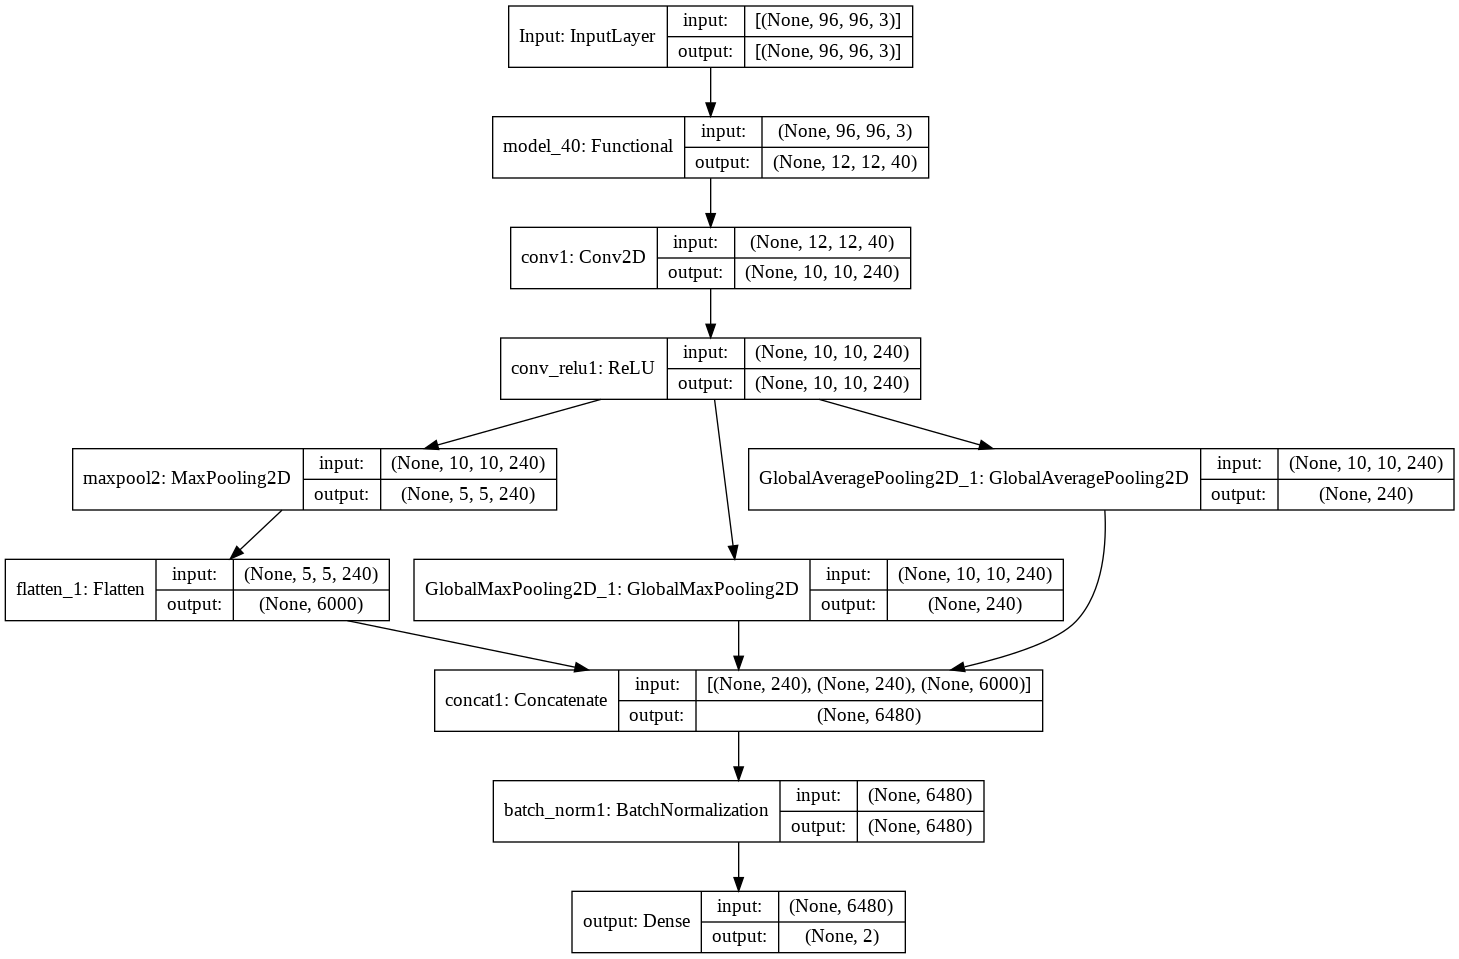

In [ ]:
### Plot do diagrama do modelo
tf.keras.utils.plot_model( model, to_file="model.png", show_shapes=True)

In [ ]:
### Compilando o modelo
model.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
### Relação de label com as pastas
print(train_gen.class_indices)
print(val_gen.class_indices)

{'a_sem_tumor': 0, 'b_com_tumor': 1}
{'a_sem_tumor': 0, 'b_com_tumor': 1}


In [ ]:
### Criando callbaks
filepath = "content/model.h5"
# Redução de Learning Rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,           #new_lr = lr * factor
                              patience=1, verbose=1, mode='min', min_lr=0.0001)
# Checkpoint (salva o modelo)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
# Interrompe o treinamento antecipadamente
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
### Treinamento do modelo
history = model.fit(train_gen, steps_per_epoch=passos_treino, 
                              validation_data=val_gen,
                              validation_steps=passos_val,
                              epochs=5, verbose=1,
                              callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/5
1200/1200 [==============================] - 141s 115ms/step - loss: 1.3976 - accuracy: 0.8642 - auc_17: 0.8847 - recall_17: 0.8642 - precision_17: 0.8642 - val_loss: 0.9201 - val_accuracy: 0.8725 - val_auc_17: 0.8991 - val_recall_17: 0.8725 - val_precision_17: 0.8725

Epoch 00001: val_accuracy improved from 0.61850 to 0.87248, saving model to content/model.h5
Epoch 2/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1200/1200 [==============================] - 135s 113ms/step - loss: 0.7812 - accuracy: 0.8694 - auc_17: 0.9011 - recall_17: 0.8694 - precision_17: 0.8694 - val_loss: 0.5892 - val_accuracy: 0.8790 - val_auc_17: 0.9155 - val_recall_17: 0.8790 - val_precision_17: 0.8790

Epoch 00002: val_accuracy improved from 0.87248 to 0.87902, saving model to content/model.h5
Epoch 3/5
1200/1200 [==============================] - 135s 112ms/step - loss: 0.5278 - accuracy: 0.8701 - auc_17: 0.9145 - recall_17: 0.8701 - precision_17: 0.8701 - val_loss: 0.4279 - val_accuracy: 0.8777 - val_auc_17: 0.9257 - val_recall_17: 0.8777 - val_precision_17: 0.8777

Epoch 00003: val_accuracy did not improve from 0.87902
Epoch 4/5
1200/1200 [==============================] - 133s 111ms/step - loss: 0.4121 - accuracy: 0.8731 - auc_17: 0.9259 - recall_17: 0.8731 - precision_17: 0.8731 - val_loss: 0.3621 - val_accuracy: 0.8830 - val_auc_17: 0.9343 - val_recall_17: 0.8830 - val_precision_17: 0.8830

Epoch 00004: val_accur

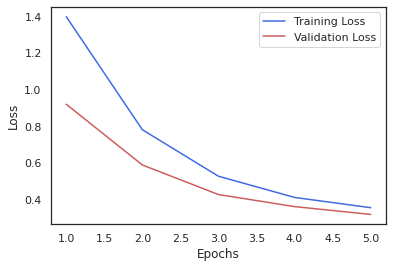

In [ ]:
### Gráfico de loss
epochs = range(1, len(history.history['loss'])+1)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']


plt.plot(epochs, training_loss, color='royalblue', label='Training Loss')
plt.plot(epochs, validation_loss, color='indianred', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

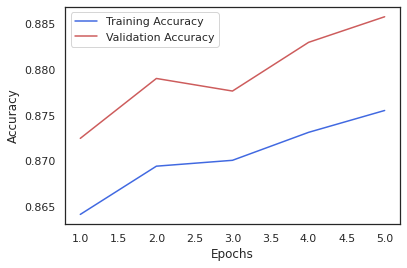

In [ ]:
### Gráfico de acurácia
epochs = range(1, len(history.history['loss'])+1)
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']


plt.plot(epochs, training_acc, color='royalblue', label='Training Accuracy')
plt.plot(epochs, validation_acc, color='indianred', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

> Se necessário, os pesos da rede podem ser restaurados para o último checkpoint realizado durante o treinamento. Útil em casos onde o modelo decaiu nas métricas observadas entre o checkpoint e o fim do treinamento.

In [ ]:
#model.load_weights('/content/content/model.h5')

### Fine-Tuning

In [ ]:
### Descongelando todos os layers do bloco 2 e 3, com exceção dos layers de batch normalization

conv_base.trainable = True      # descongela toda a base
flag = False

for layer in conv_base.layers:
    if layer.name.startswith('block2'):
        flag = True         # Flag verdadeira após o primeiro layer do bloco 2
    
    # Congela o layer se ele for batch normalization
    if layer.name.endswith('bn'):
            layer.trainable = False
            continue

    # Se a flag estiver ativa (True), o layer permanece descongelado.
    if flag:
        layer.trainable = True
    # Caso contrário o layer é congelado
    else:
        layer.trainable = False

> Segundo treinamento

In [ ]:
model.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
filepath = "content/model-ft.h5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,   #new_lr = lr * factor
                              patience=2, verbose=1, mode='min', min_lr=0.00005)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=8)

In [ ]:
history = model.fit(train_gen, steps_per_epoch=passos_treino, 
                              validation_data=val_gen,
                              validation_steps=passos_val,
                              epochs=60, verbose=1,
                              callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/60
1200/1200 [==============================] - 258s 211ms/step - loss: 0.2897 - accuracy: 0.8888 - auc_18: 0.9473 - recall_18: 0.8888 - precision_18: 0.8888 - val_loss: 0.2643 - val_accuracy: 0.9010 - val_auc_18: 0.9544 - val_recall_18: 0.9010 - val_precision_18: 0.9010

Epoch 00001: val_accuracy improved from -inf to 0.90095, saving model to content/model-ft.h5
Epoch 2/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1200/1200 [==============================] - 252s 210ms/step - loss: 0.2168 - accuracy: 0.9168 - auc_18: 0.9665 - recall_18: 0.9168 - precision_18: 0.9168 - val_loss: 0.2669 - val_accuracy: 0.8943 - val_auc_18: 0.9533 - val_recall_18: 0.8943 - val_precision_18: 0.8943

Epoch 00002: val_accuracy did not improve from 0.90095
Epoch 3/60
1200/1200 [==============================] - 251s 209ms/step - loss: 0.1907 - accuracy: 0.9278 - auc_18: 0.9725 - recall_18: 0.9278 - precision_18: 0.9278 - val_loss: 0.3072 - val_accuracy: 0.8885 - val_auc_18: 0.9421 - val_recall_18: 0.8885 - val_precision_18: 0.8885

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 00003: val_accuracy did not improve from 0.90095
Epoch 4/60
1200/1200 [==============================] - 250s 208ms/step - loss: 0.1694 - accuracy: 0.9359 - auc_18: 0.9772 - recall_18: 0.9359 - precision_18: 0.9359 - val_loss: 0.1725 - val_accuracy: 0.9353 - val_auc_18: 0.9778 - val_recall_18: 0.9353 - val_

In [ ]:
#loss: 0.0911 - accuracy: 0.9678 - auc_2: 0.9923 - recall_2: 0.9678
#val_loss: 0.0794 - val_accuracy: 0.9733 - val_auc_2: 0.9925 - val_recall_2: 0.9733

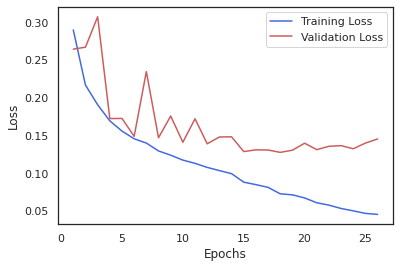

In [ ]:
### Gráfico de loss
epochs = range(1, len(history.history['loss'])+1)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(epochs, training_loss, color='royalblue', label='Training Loss')
plt.plot(epochs, validation_loss, color='indianred', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

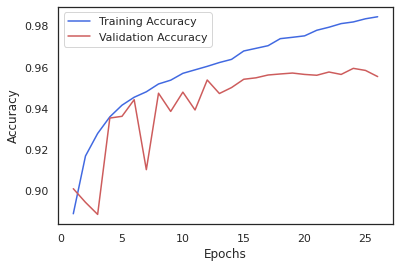

In [ ]:
### Gráfico de acurácia
epochs = range(1, len(history.history['loss'])+1)
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

plt.plot(epochs, training_acc, color='royalblue', label='Training Accuracy')
plt.plot(epochs, validation_acc, color='indianred', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
#model.load_weights('/content/content/model-ft.h5')

In [ ]:
### Salva o modelo
model.save('/model')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /model/assets


INFO:tensorflow:Assets written to: /model/assets


In [ ]:
### Zipa a pasta
!zip -r /content/model-120k-30052021.zip /model

  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 94%)
  adding: model/saved_model.pb (deflated 90%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: model/variables/variables.index (deflated 73%)


In [ ]:
### Salva os pesos do modelo
model.save_weights('treino-30052021.h5')

# Avaliação do Modelo

## Conjunto de Validação

In [ ]:
# Avaliação feita pelo próprio Keras
stats = model.evaluate(val_gen)

400/400 [==============================] - 34s 84ms/step - loss: 0.1324 - accuracy: 0.9594 - auc_18: 0.9819 - recall_18: 0.9594 - precision_18: 0.9594


## Conjunto de Testes 1 (Local)

In [ ]:
imagens_batch = test1_gen.next()    # Carrega as imagens
y_teste = imagens_batch[1]              # Separa os labels
imagens_teste = imagens_batch[0]        # Armazena só as imagens

In [ ]:
y_teste.shape

(18000, 2)

In [ ]:
imagens_teste.shape

(18000, 96, 96, 3)

In [ ]:
# Criando um vetor com o resultado da predição
predictions = model.predict(imagens_teste)
predictions.shape

(18000, 2)

In [ ]:
### Transforma a classificação. Como há 2 neurônios na saída, cada predição é uma lista com 2 valores.
    # essa célula transforma esse array em um formato (455, 1)
def pred_refactor(arr):
    if arr[0] > arr[1]:
        return 0
    else:
        return 1

predictions = np.apply_along_axis(pred_refactor, 1, predictions)
y_teste = np.apply_along_axis(pred_refactor, 1, y_teste)

### Métricas (SKLearn)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

In [ ]:
# Acc
print("Acurácia:", accuracy_score(y_teste, predictions))

Acurácia: 0.9578888888888889


In [ ]:
# ROC AUC
print("ROC AUC:", roc_auc_score(y_teste, predictions))

ROC AUC: 0.9578888888888889


In [ ]:
# Recall, precision e F1
print("Recall:", recall_score(y_teste, predictions))
print("Precision:", precision_score(y_teste, predictions))
print("F1 Score: ", f1_score(y_teste, predictions))

Recall: 0.9595555555555556
Precision: 0.9563676633444075
F1 Score:  0.9579589572933999


### Matriz de Confusão

In [ ]:
# Matriz de confusão
confusion_matrix(y_teste, predictions)

array([[8606,  394],
       [ 364, 8636]])

In [ ]:
# Labels
print(test1_gen.class_indices)

{'a_sem_tumor': 0, 'b_com_tumor': 1}


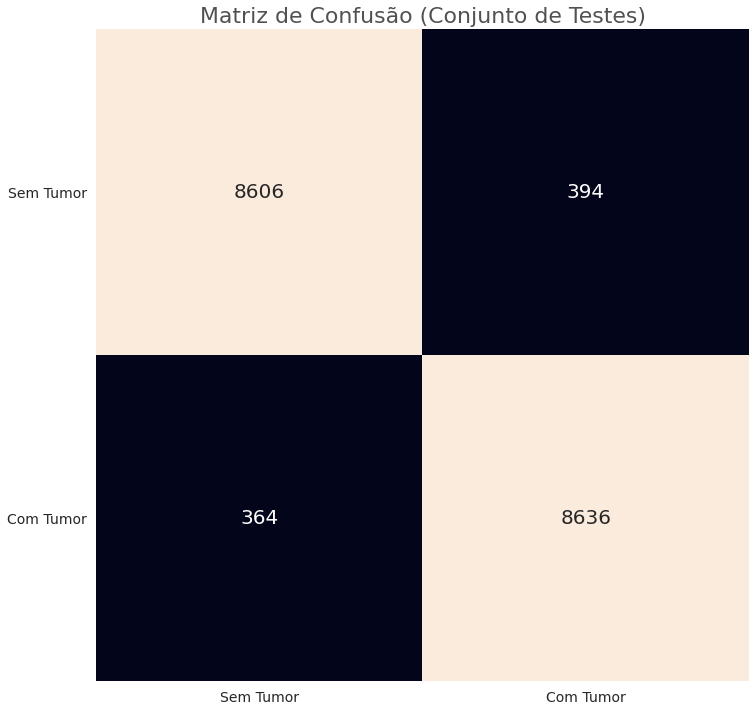

In [ ]:
# Criando um DataFrame. O índice e as colunas são os nomes dos batimentos, os valores são os retornados pela matriz de confusão
df_cm = pd.DataFrame(confusion_matrix(y_teste, predictions), index = ["Sem Tumor", "Com Tumor"],
                  columns = ["Sem Tumor", "Com Tumor"])

# Criando uma figura 12x12
plt.figure(figsize = (12,12))

# Criando um heatmap com base no dataframe criado anteriormente
ax = sns.heatmap(df_cm,
                 annot=True,  # ativa a anotação dos valores dentro dos quadrados
                 fmt='g',   # retira a notação científica dos valores
                 cbar=False,  # retira o cbar da imagem
                 square=True, # plot em forma de quadrados
                 annot_kws={"fontsize":20}) # define o tamanho da fonte dos números

# Define tamanho da fonte dos labels dos eixos x e y
plt.yticks(fontsize=14, rotation=0)
plt.xticks(fontsize=14)

# Adiciona um título
plt.title("Matriz de Confusão (Conjunto de Testes)", size=22, alpha=0.8)

plt.show();

## Conjunto de Testes (Kaggle)

In [ ]:
### Gera as predições no conjunto de testes do Kaggle
predictions = model.predict(test_gen, verbose=1)

57458/57458 [==============================] - 371s 6ms/step


In [ ]:
predictions.shape

(57458, 2)

In [ ]:
### Gera um DF com as predições
df_preds = pd.DataFrame(predictions, columns=['sem_tumor', 'com_tumor'])
df_preds.head()

,sem_tumor,com_tumor
0,1.480524e-09,1.000000e+00
1,5.607407e-07,9.999994e-01
2,1.256014e-08,1.000000e+00
3,6.741316e-01,3.258684e-01
4,1.000000e+00,4.499681e-13


In [ ]:
### Cria uma coluna com o caminho de cada imagem
df_preds['file_names'] = test_gen.filenames

In [ ]:
df_preds.head()

,sem_tumor,com_tumor,file_names
0,1.480524e-09,1.000000e+00,test/00006537328c33e284c973d7b39d340809f7271b.tif
1,5.607407e-07,9.999994e-01,test/0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,1.256014e-08,1.000000e+00,test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,6.741316e-01,3.258684e-01,test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,1.000000e+00,4.499681e-13,test/000270442cc15af719583a8172c87cd2bd9c7746.tif


In [ ]:
### Extrai o ID das imagens (necessário para enviar ao Kaggle)
def extract_id(x):
    a = x.split('/')
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,sem_tumor,com_tumor,file_names,id
0,1.480524e-09,1.000000e+00,test/00006537328c33e284c973d7b39d340809f7271b.tif,00006537328c33e284c973d7b39d340809f7271b
1,5.607407e-07,9.999994e-01,test/0000ec92553fda4ce39889f9226ace43cae3364e.tif,0000ec92553fda4ce39889f9226ace43cae3364e
2,1.256014e-08,1.000000e+00,test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,6.741316e-01,3.258684e-01,test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,1.000000e+00,4.499681e-13,test/000270442cc15af719583a8172c87cd2bd9c7746.tif,000270442cc15af719583a8172c87cd2bd9c7746


In [ ]:
### Mantendo apenas a coluna "com_tumor", pois o desafio solicita a possibilidade de conter tumor nas imagens
y_pred = df_preds['com_tumor']
image_id = df_preds['id']

In [ ]:
### Cria o arquivo a ser submetido
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

In [ ]:
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,1.000000e+00
0000ec92553fda4ce39889f9226ace43cae3364e,9.999994e-01
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,1.000000e+00
000253dfaa0be9d0d100283b22284ab2f6b643f6,3.258684e-01
000270442cc15af719583a8172c87cd2bd9c7746,4.499681e-13


In [ ]:
### Salva o arquivo como .csv
submission.to_csv('patch_preds.csv', columns=['label']) 

In [ ]:
### Envia à plataforma
!kaggle competitions submit -c histopathologic-cancer-detection -f /content/patch_preds.csv -m "Submission 01"

100% 2.86M/2.86M [00:09<00:00, 316kB/s]
Successfully submitted to Histopathologic Cancer Detection

>Score:

> ROC AUC Score (Public): 0.9495
>
> ROC AUC Score (Private): 0.9498